# Optimizing the training

This notebooks covers more details on tweaking and optimizing the training process.

In [1]:
import os, warnings
import tensorflow as tf

import matplotlib.pyplot as plt

from glob import glob
from pinn.io import load_qm9, sparse_batch
from pinn.networks import pinet
from pinn.utils import get_atomic_dress
from pinn.models import potential_model

os.environ['CUDA_VISIBLE_DEVICES'] = ''
index_warning = 'Converting sparse IndexedSlices'
warnings.filterwarnings('ignore', index_warning)

## Optimizing the pipeline
### Caching
Caching stores the decoded dataset in the memory.

In [2]:
# For the purpose of testing, we use only 1000 samples from QM9
filelist = glob('/home/yunqi/datasets/QM9/dsgdb9nsd/*.xyz')[:1000]
dataset = lambda: load_qm9(filelist, split=1)

In [3]:
d = dataset().repeat().apply(sparse_batch(100))
tensors = d.make_one_shot_iterator().get_next()
with tf.Session() as sess:
    for i in range(10):
        sess.run(tensors) # "Warm up" the graph
    %timeit sess.run(tensors)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
52.4 ms ± 701 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


This speed indicates the IO limit of our current setting.

Now let's cache the dataset to the memory.

In [4]:
d = dataset().cache().repeat().apply(sparse_batch(100))
tensors = d.make_one_shot_iterator().get_next()
with tf.Session() as sess:
    for i in range(10):
        sess.run(tensors) # "Warm up" the graph, dataset is cached here
    %timeit sess.run(tensors)

285 µs ± 10.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Preprocessing
You might also see a notable difference in the performance with and without preprocessing. This is especially helpful when you are training with GPUs.

In [5]:
d = dataset().cache().repeat().apply(sparse_batch(100))
tensors = d.make_one_shot_iterator().get_next()
output = pinet(tensors)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(10):
        sess.run(output)
    %timeit sess.run(output)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
37.4 ms ± 2.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
tf.reset_default_graph()

pre_fn = lambda tensors: pinet(tensors, preprocess=True)
d = dataset().cache().repeat().apply(sparse_batch(100)).map(pre_fn, 8)
tensors = d.make_one_shot_iterator().get_next()
output = pinet(tensors)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(10):
        sess.run(output)
    %timeit sess.run(output)

27.2 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


You can even cache the preprocessed data.

In [7]:
tf.reset_default_graph()

pre_fn = lambda tensors: pinet(tensors, preprocess=True)
d = dataset().apply(sparse_batch(100)).map(pre_fn).cache().repeat()
tensors = d.make_one_shot_iterator().get_next()
output = pinet(tensors)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(10):
        sess.run(output)
    %timeit sess.run(output)

27.1 ms ± 948 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Atomic dress
Scaling and aligning the labels can 
enhance the performance of the models, and avoid numerical instability.
For datasets like QM9, we can assign an atomic energy to each atom according
to their elements to approximate the total energy. This can be done by a simple 
linear regression. We provide a simple tool to generate such "atomic dresses".

In [8]:
filelist = glob('/home/yunqi/datasets/QM9/dsgdb9nsd/*.xyz')
dataset = lambda: load_qm9(filelist, split={'train':8, 'test':2})
dress, error = get_atomic_dress(dataset()['train'],[1,6,7,8,9],max_iter=2000)

Applying the atomic dress converts the QM9 energies to a "normal" distribution.
It also gives us some ideas about the relative distribution of energies, and 
how much our neural network improves from the naive guess of the atomic dress.

After applying the atomic dress, it turns out that the distribution of our training set is only about 0.05 Hartree, or 30 kcal/mol.

{1: -0.6039418437152411,
 6: -38.07358460885415,
 7: -54.75154708631868,
 8: -75.22503739913694,
 9: -99.87073186940984}

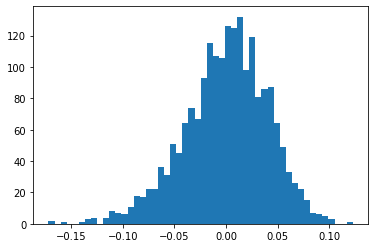

In [9]:
plt.hist(error,50)
dress

## Training with the optimized pipeline

In [10]:
params = {'model_dir': '/tmp/PiNet_QM9_pipeline',
          'network': 'pinet',
          'network_params': {
              'atom_types':[1, 6, 7, 8, 9],
          },
          'model_params': {
              'learning_rate': 1e-3, # Relatively large learning rate
              'e_scale': 627.5, # Here we scale the model to kcal/mol
              'e_dress': dress
          }}

# The logging behavior of estimator can be controlled here
config = tf.estimator.RunConfig(log_step_count_steps=500)

# Preprocessing the datasets
pre_fn = lambda tensors: pinet(tensors, preprocess=True, **params['network_params'])
train = lambda: dataset()['train'].cache().repeat().shuffle(1000).apply(sparse_batch(100)).map(pre_fn, 8)
test = lambda: dataset()['test'].cache().repeat().apply(sparse_batch(100)).map(pre_fn, 8)

# Running specs
train_spec = tf.estimator.TrainSpec(input_fn=train, max_steps=1e4)
eval_spec = tf.estimator.EvalSpec(input_fn=test, steps=100)

In [11]:
model = potential_model(params, config=config)
tf.estimator.train_and_evaluate(model, train_spec, eval_spec)

INFO:tensorflow:Using config: {'_model_dir': '/tmp/PiNet_QM9_pipeline', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 500, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd1b8213240>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. 

({'METRICS/E_LOSS': 36.76002,
  'METRICS/E_MAE': 4.2175436,
  'METRICS/E_RMSE': 6.0630045,
  'METRICS/TOT_LOSS': 36.760036,
  'loss': 36.760036,
  'global_step': 10000},
 [])

## Monitoring
It's recommended to monitor the training with Tensorboard instead of the stdout here.  
Try `tensorboard --logdir /tmp`, and you can probably see this.

![](tensorboard.png)


## Parallelization with tf.Estimator

The estimator api makes it extremely easy to train on multiple GPUs.

In [12]:
# suppose you have two cards
distribution = tf.contrib.distribute.MirroredStrategy(num_gpus=2)
config = tf.estimator.RunConfig(train_distribute=distribution)
model = potential_model(params, config=config)

INFO:tensorflow:Device is available but not used by distribute strategy: /device:CPU:0
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_CPU:0
INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/PiNet_QM9_pipeline', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': <tensorflow.contrib.distribute.python.mirrored_strategy.MirroredStrategy object at 0x7fd0dc1b5cc0>, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_l

## Conclusions

Congratulations! You can now train atomic neural networks with 
state-of-the-art accuracy and speed.


But there's more. With PiNN, the components of ANNs are modulized.
Read the following notebooks to see how you can build your own ANN. 